In [48]:
from comm_utils import load_server_data, load_client_data, process_rounds_time, filter_round_time, network_log_to_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from types import SimpleNamespace
from box import Box
import json
import sys

In [60]:
exp_path = "/Users/Slaton/Documents/grenoble-code/fl-flower/energyfl/outputcifar10/10clients/comm/fedavg/labelskew/2024-04-26_04-43-45"

In [61]:
def read_server_clients_data(exp_path):
    host_ids = [int(name.split('_')[-1]) for name in os.listdir(exp_path) if 'client' in name]
    outputs = Box()
    for i in host_ids:
        client_processes, client_fittimes, client_energy, client_network, client_df = load_client_data(exp_path, i)
        outputs[f'client_{i}'] = Box(processes=client_processes, energy=client_energy, time=client_fittimes, network=client_network, log=client_df)
    server_path = os.path.join(exp_path, 'server')
    server_processes, server_energy, server_time, server_network, server_df = load_server_data(exp_path)
    outputs['server'] = Box(processes=server_processes, energy=server_energy, time=server_time, network=server_network, df=server_df)
    return outputs

In [62]:
files = read_server_clients_data(exp_path)

In [63]:
files.server.keys()

dict_keys(['processes', 'energy', 'time', 'network', 'df'])

In [64]:
server_round_time = process_rounds_time(files.server.time, mode='round')
client_0_round_time = filter_round_time(server_round_time, files.client_0.network)
client_0_round_time

,timestamp,process,send,receive,round,round time
10,2024-04-26 04:44:52.248238,python3/147459/0,0.563477,0.857227,1,47.927662
11,2024-04-26 04:44:53.252207,python3/147459/0,0.563477,0.857227,1,47.927662
12,2024-04-26 04:44:54.022394,python3/147459/0,13.275400,5171.910000,1,47.927662
13,2024-04-26 04:44:55.440259,python3/147459/0,22.174000,8765.040000,1,47.927662
14,2024-04-26 04:44:56.315707,python3/147459/0,22.174000,8765.040000,1,47.927662
...,...,...,...,...,...,...
7819,2024-04-26 06:55:05.880748,python3/147459/0,8760.790000,73.025600,200,37.750394
7820,2024-04-26 06:55:06.717382,python3/147459/0,0.253320,35.879300,200,37.750394
7821,2024-04-26 06:55:07.030000,python3/147459/0,5.203320,1987.160000,200,37.750394
7822,2024-04-26 06:55:08.032938,python3/147459/0,18.106800,7099.210000,200,37.750394


In [65]:
def process_host_round_time(files_holder, host:str):
    server_round_time = process_rounds_time(files_holder.server.time, mode='round')
    host_round_time = filter_round_time(server_round_time, files_holder[host].network)
    send, receives = [], []
    rounds = host_round_time['round'].unique()
    for r in rounds:
        send_r = host_round_time[host_round_time['round'] == r]['send'].sum()/1024
        receive_r = host_round_time[host_round_time['round'] == r]['receive'].sum()/1024
    return host_round_time

ok = process_host_round_time(files, 'client_0')
ok

,timestamp,process,send,receive,round,round time
10,2024-04-26 04:44:52.248238,python3/147459/0,0.563477,0.857227,1,47.927662
11,2024-04-26 04:44:53.252207,python3/147459/0,0.563477,0.857227,1,47.927662
12,2024-04-26 04:44:54.022394,python3/147459/0,13.275400,5171.910000,1,47.927662
13,2024-04-26 04:44:55.440259,python3/147459/0,22.174000,8765.040000,1,47.927662
14,2024-04-26 04:44:56.315707,python3/147459/0,22.174000,8765.040000,1,47.927662
...,...,...,...,...,...,...
7819,2024-04-26 06:55:05.880748,python3/147459/0,8760.790000,73.025600,200,37.750394
7820,2024-04-26 06:55:06.717382,python3/147459/0,0.253320,35.879300,200,37.750394
7821,2024-04-26 06:55:07.030000,python3/147459/0,5.203320,1987.160000,200,37.750394
7822,2024-04-26 06:55:08.032938,python3/147459/0,18.106800,7099.210000,200,37.750394


In [55]:
def plot_multples_clients(file_holder):
    server_time = file_holder.server.time
    clients = sorted([client for client in file_holder.keys() if 'client' in client])
    server_round_time = process_rounds_time(server_time, mode='round')
    server_filter = filter_round_time(server_round_time, file_holder.server.network)
    
    fig, axs = plt.subplots(2, 1, figsize=(20, 5))
    rounds = server_filter['round'].unique()
    for client in clients:
        client_network = file_holder[client].network
        client_filtered = filter_round_time(server_round_time, client_network)
        sends, receives = [], []
        for r in rounds:
            send_sum = client_filtered[client_filtered['round'] == r].send.sum()/1024
            recv_sum = client_filtered[client_filtered['round'] == r].receive.sum()/1024
            sends.append(send_sum)
            receives.append(recv_sum)
        axs[0].plot(rounds, sends, label=f"{client}")#,marker='^', markevery=1, linewidth=2)
        axs[1].plot(rounds, receives, label=f"{client}")#,marker='^', markevery=1, linewidth=2)
    
    axs[0].set_title("Send")
    axs[1].set_title("Receive")
    axs[0].set_ylabel("MB")
    axs[1].set_ylabel("MB")
    axs[1].set_xlabel("Round")
    legend = fig.legend(clients, 
                        loc="upper center", 
                        bbox_to_anchor=(0.5, 1.0), 
                        ncol=len(clients),
                        fontsize=12,)
    
    fig_server, axs_server = plt.subplots(2, 1, figsize=(20, 5))
    server_sends, server_receives = [], []
    for r in rounds:
        send_sum = server_filter[server_filter['round'] == r].send.sum()/1024
        recv_sum = server_filter[server_filter['round'] == r].receive.sum()/1024
        server_sends.append(send_sum)
        server_receives.append(recv_sum)
    axs_server[0].bar(rounds, server_sends, label="Server")#,marker='^', markevery=1, linewidth=2)
    axs_server[1].bar(rounds, server_receives, label="Server")#,marker='^', markevery=1, linewidth=2)
    axs_server[0].set_title("Send")
    axs_server[1].set_title("Receive")
    axs_server[0].set_ylabel("MB")
    axs_server[1].set_ylabel("MB")
    axs_server[0].set_xlabel("Round")
    legend = fig_server.legend(["Server"], 
                        loc="upper center", 
                        bbox_to_anchor=(0.5, 1.0), 
                        ncol=1,
                        fontsize=12,)

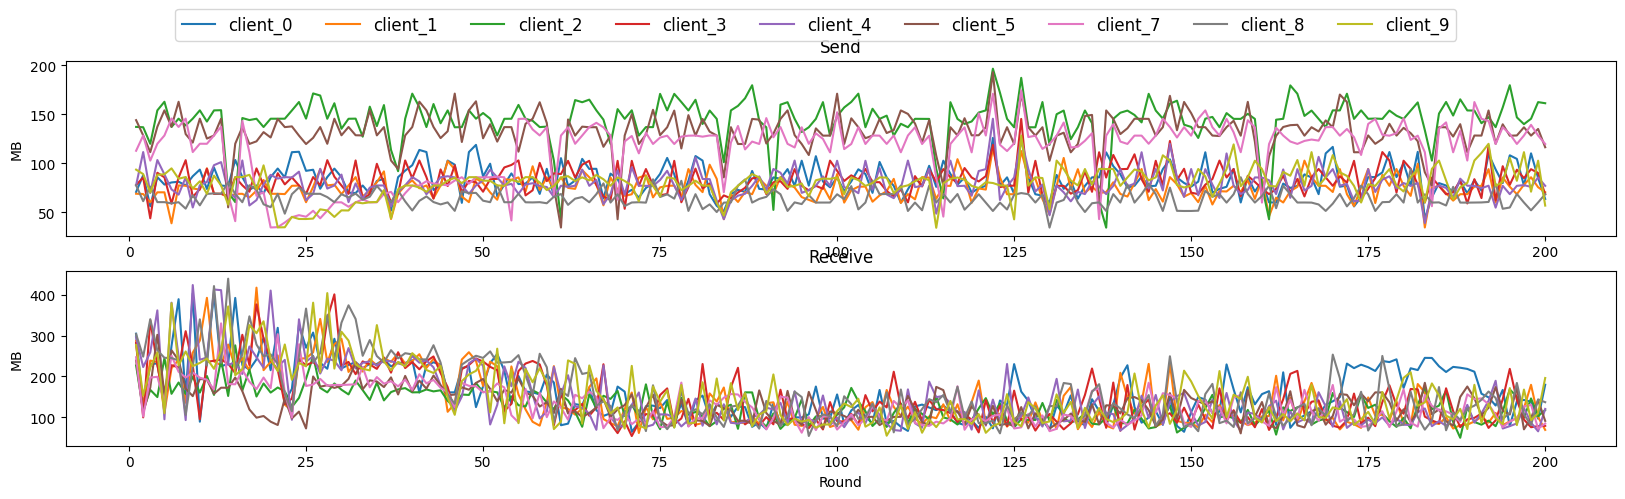

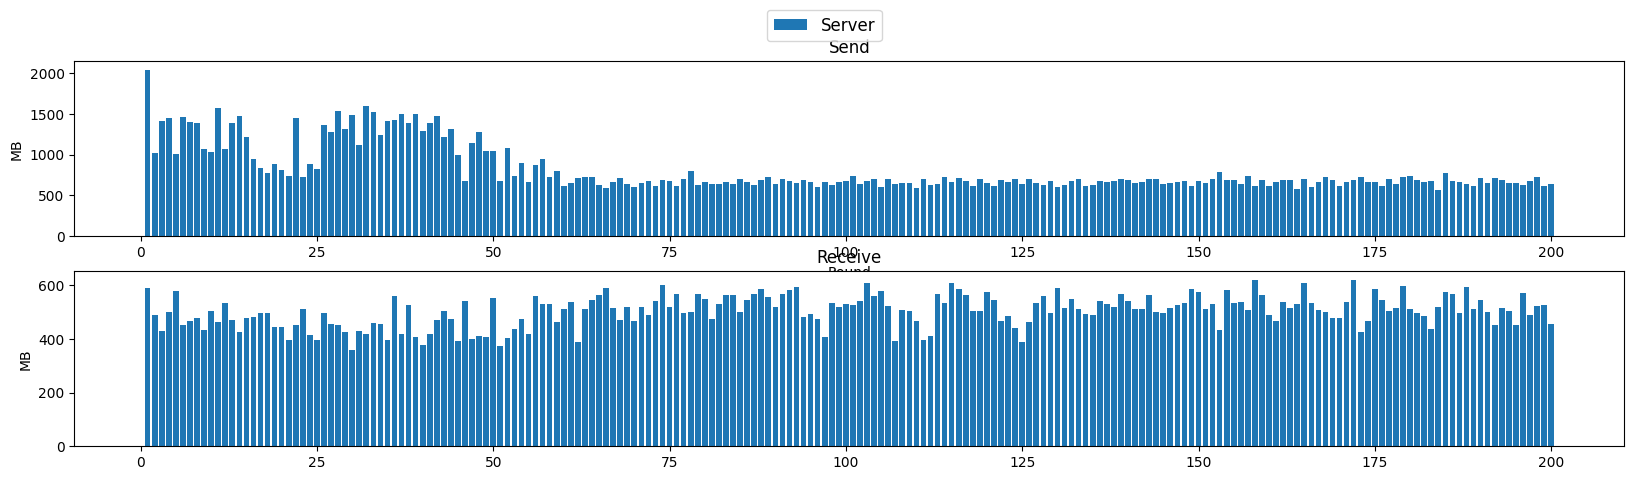

In [66]:
plot_multples_clients(files)

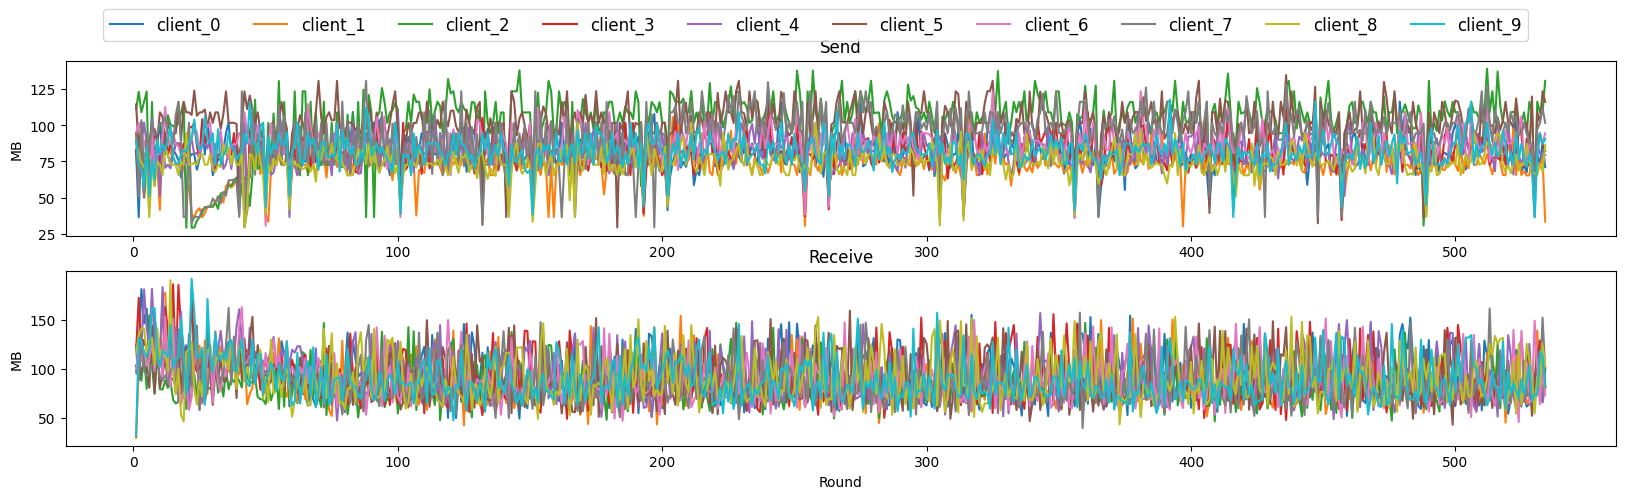

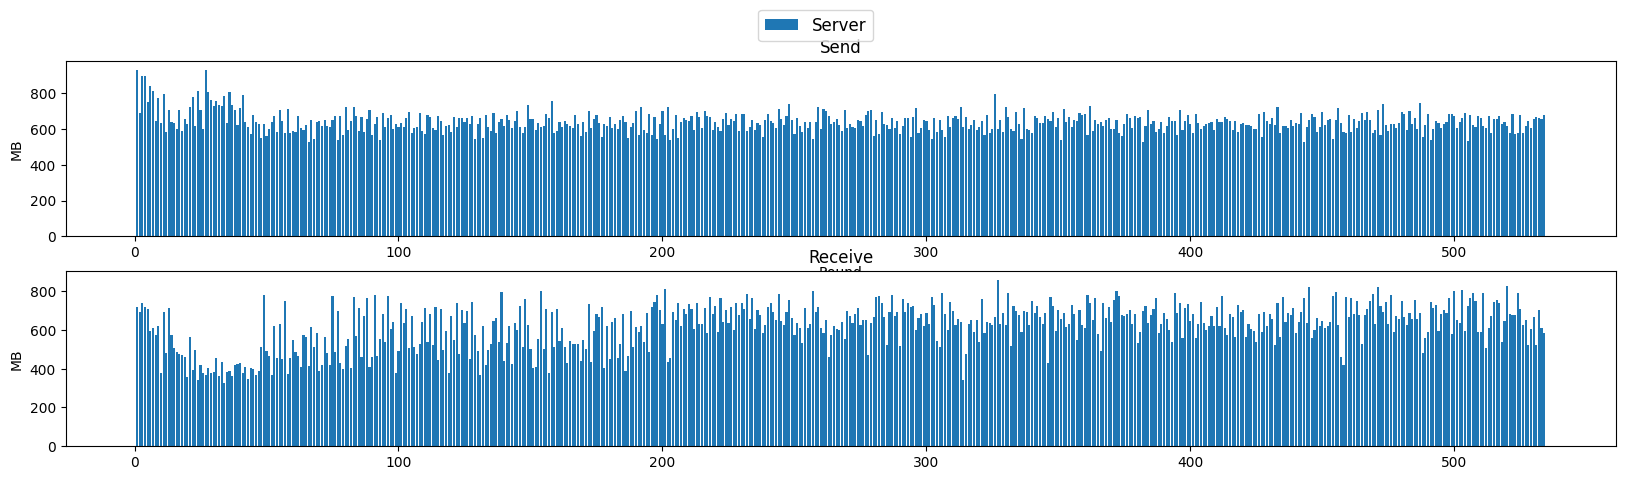

In [56]:
plot_multples_clients(files)